# Chapter 5

In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 5.1 Spurious association

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, a, bA]
100%|██████████| 2000/2000 [00:02<00:00, 728.90it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119d13b70>,
      dtype=object)

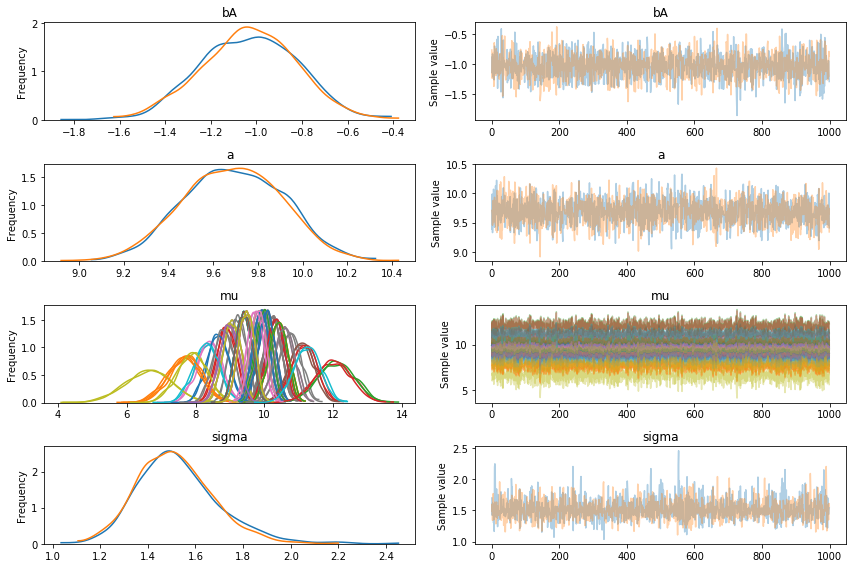

In [31]:
# 5.1
d = pd.read_csv('../data/WaffleDivorce.csv', sep = ';')
d = d.assign(MedianAgeMarriage_s = pd.Series((d.MedianAgeMarriage - np.mean(d.MedianAgeMarriage))/np.std(d.MedianAgeMarriage)).values)
with pm.Model() as m5_1:
    bA = pm.Normal('bA', 0, 1)
    a = pm.Normal('a', 10, 10)
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    sigma = pm.Uniform('sigma', 0, 10)
    Divorce = pm.Normal('Divorce', mu, sigma, observed = d.Divorce)
    trace_5_1 = pm.sample(1000, tune = 1000)

pm.traceplot(trace_5_1)

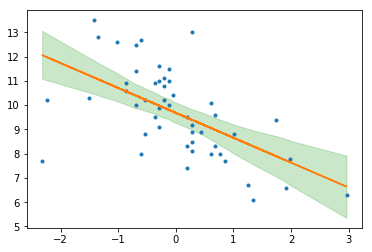

In [44]:
# 5.2
mu5_1_hpd = pm.hpd(trace_5_1['mu'])
plt.plot(d.MedianAgeMarriage_s, d.Divorce, '.')
plt.plot(d.MedianAgeMarriage_s, trace_m5_1['mu'].mean(0), '-')
idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx],
                 mu5_1_hpd[:,0][idx], mu5_1_hpd[:,1][idx], color='C2', alpha=0.25)

In [47]:
# 5.3
d = d.assign(Marriage_s = pd.Series((d.Marriage - np.mean(d.Marriage))/np.std(d.Marriage)).values)
with pm.Model() as m5_2:
    bA = pm.Normal('bA', 0, 1)
    a = pm.Normal('a', 10, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', a + bA * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu, sigma, observed = d.Divorce)
    trace_5_2 = pm.sample(1000, tune = 1000)
    
pm.summary(trace_5_2).head()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, a, bA]
100%|██████████| 2000/2000 [00:02<00:00, 989.14it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bA,0.637726,0.238133,0.005398,0.164338,1.075757,2000.0,1.000147
a,9.691179,0.243776,0.004617,9.210054,10.151097,2000.0,0.999974
sigma,1.755784,0.184025,0.004262,1.426226,2.132906,1814.0,1.000230
mu__0,9.705767,0.244153,0.004604,9.225257,10.166531,2000.0,0.999948
mu__1,10.689562,0.457132,0.009127,9.823648,11.593010,2000.0,0.999583


### 5.1.2 Fitting the model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, bA, a]
100%|██████████| 2000/2000 [00:03<00:00, 573.40it/s]


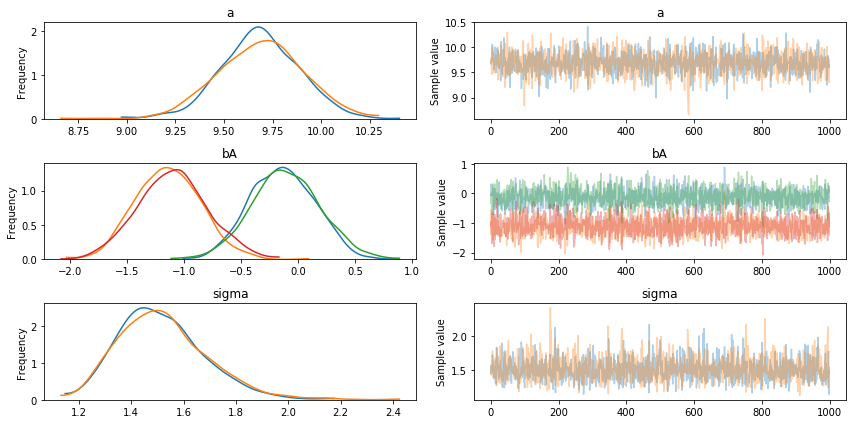

In [48]:
# 5.4
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000, tune=1000)

varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [51]:
pm.summary(trace_5_3, varnames, alpha = 0.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.683,0.212,0.006,9.335,10.000,1588.0,1.000
bA__0,-0.123,0.290,0.007,-0.593,0.329,1572.0,1.004
bA__1,-1.118,0.294,0.007,-1.579,-0.633,1474.0,1.005
sigma,1.519,0.167,0.004,1.246,1.752,1563.0,1.001


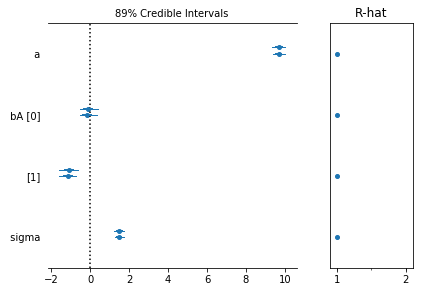

In [52]:
# 5.5
pm.forestplot(trace_5_3, varnames=varnames, alpha = 0.11)

### 5.1.3 Plotting multivariate posteriors